# 12 k-nearest neighbors

Part of ["Introduction to Data Science" course](https://github.com/kupav/data-sc-intro) by Pavel Kuptsov, [kupav@mail.ru](mailto:kupav@mail.ru)

Recommended reading for this section:

1. Grus, J. (2019). Data Science From Scratch: First Principles with Python (Vol. Second edition). Sebastopol, CA: O’Reilly Media
1. Muller, A and Guido, S (2017). Introduction to Machine Learning with Python. O'Reilly
1. Shmueli, B. Multi-Class Metrics Made Simple, Part I: Precision and Recall. https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2
1. Shmueli, B. Multi-Class Metrics Made Simple, Part II: the F1-score. https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

The following Python modules will be required. Make sure that you have them installed.
- `matplotlib`
- `sklearn`
- `csv`
- `requests`
- `numpy`
- `collections`

## Lesson 1

### Idea of k-nearest neighbors method

k-nearest neighbors or kNN methods is the simplest supervised learning method.

Let us remember:

Supervised means that we train a model using an annotated dataset: each for each record the desired output is known.

kNN method can be used both for classification and for regression.

Let us remember:

- Classification means that all data can be categorized into several classes. If there are two classes this is binary
classification: spam or not spam. The goal of training is to built a model that predicts a class for a new previously unseen data.
- Regression means that the data represent an unknown dependence like $y=f(x)$. Here $x$ and $y$ are real numbers. The goal is 
to build a model able to predict real value $y$ for a new, previously unseen real value $x$.

Common idea behind the nearest neighbors method is simple and intuitively obvious:

If you want to know somebody's preferences, e.g. preferred shopping areas or cinemas, look around at his/her closest neighbors. The preferences most probably will be the same.

### kNN classification

When the dataset is analyzed we locate each record as a point in a multidimensional space. 

The training merely means that a model remembers the all train data with the corresponding labels. 

When a new data point arrives the distances are computed between it and the all the stored training data to reveal its $k$ nearest neighbors. 

Value of $k$ is specified as a model parameter. It can be 1 or 3 or something like that. Usually this is not too large.

When considering more then one neighbors, they vote to assign a label. 

This means that it is counted how many neighbors belong to each class. The new point is assigned a more frequent label.

If for example $k=3$ and there are 2 classes. For a given data point the model have found neighbors with the following classes: (0, 0, 1). 

In this case the point will be labeled as belonging to the class 0.

Assume however that we consider $k=5$ and 3 classes. 

It is possible that among the neighbors two different classes will appear twice: The neighbors can be like this (0,0,1,1,2).

What class to choose, 0 or 1?

Such situations are called ties.

Their resolution depend on the implementation of the kNN model. There are several options:

- Pick the winning first class in a list of neighbors.
- Pick one of the winners at random.
- Weight the votes by distance and pick the weighted winner.
- Reduce k until we find a unique winner.

### kNN classification in more detail: manually implemented model

Since kNN method is very simple we will implements it first ourself, and then consider its implementation from the library "scikit-learn".

First we will need as usual a function to download datasets from the repository.

In [ ]:
import csv
import numpy as np
import requests

def load_csv_dataset(file_name, dtype=float):
    """Downloads csv numeric dataset from repo to numpy array."""
    base_url = "https://raw.githubusercontent.com/kupav/data-sc-intro/main/data/"
    web_data = requests.get(base_url + file_name)
    assert web_data.status_code == 200
    
    reader = csv.reader(web_data.text.splitlines(), delimiter=',')
    data = []
    for row in reader:
        try:
            # Try to parse as a row of floats
            float_row = [dtype(x) for x in row]
            data.append(float_row)
        except ValueError:
            # If parsing as floats failed - this is header
            print(row)
            
    return np.array(data)

To implement a function that finds neighbors we need take a look at two functions.

Function `np.linalg.norm` computes Euclidean norm of a vector. For example for vectors of two elements 
it computes hypotenuse length considering vector elements as a triangle legs lengths (Pythagorean theorem):

In [ ]:
leg1, leg2 = 3, 4
hyp = np.sqrt(leg1**2 + leg2**2)
print(hyp)
vec = [leg1, leg2]
nrm = np.linalg.norm(vec)
print(nrm)

kNN-method computes distances between the stored training data and a new point. 

In principal the various distances can be considered. We will use the most standard Euclidean one. It will be computed using 
the function `np.linalg.norm`.

Another function that we will use is `sorted`. It does what is expected: returns an array sorted in the ascending order.

In [ ]:
arr1 = [3, 1, 4, 2]
arr2 = sorted(arr1)
print(arr2)

We will need to sort array of two columns in parallel according to the values of one of the columns.

We do it using `key` parameter of the function `sorted`. 

Here the function is passed that take row of the sorted array and returns the value that must be sorted.

In [ ]:
arr1 = np.array([[3, 50], [1, 30], [4, 20], [2, 60]])
print("arr1=\n", arr1)
arr2 = np.array(sorted(arr1, key=lambda row: row[0]))
print("arr2=\n", arr2)

Assume that we already have $k$ labels of the closest neighbors. 

How to choose one of them?

Let us first remember how class Counter works.

In [ ]:
from collections import Counter

# Assume we obtained these labels
klabels = [0, 1, 2, 1, 2, 1, 1, 2]
# Count them
cnt = Counter(klabels)
print(cnt)

In [ ]:
# Order of elements printed above is arbitary. We want to sort the output by the number of appearence
print(cnt.most_common())

In [ ]:
# In fact we need just the first most commont element
print(cnt.most_common(1))

In [ ]:
# The most common label
print(cnt.most_common(1)[0][0])

Here the function that just takes the first most common label. 

In [ ]:
from collections import Counter

def vote_first(klabels):
    """Take the most common label among k neighbors.
    If there are many such ones just take first of them
    """
    cnt = Counter(klabels)
    return cnt.most_common(1)[0][0]

Let us check it:

In [ ]:
# Label 0 appears first. It will be returned
labels1 = [0,0,1,1,2]
print("winner=", vote_first(labels1))

# Now label 1 appears first
labels2 = [1,1,0,0,2]
print("winner=", vote_first(labels2))

The labels appear in a list of labels according to the distances of the corresponding neighbors.

When the label 0 appears first in a list like this (0,1,0,1,2) it means that the corresponding neighbor has the closest distance to the new point.

Thus taking it as a winner makes sense. 

More sophisticated approach can be as follows. 

In cases of ties we will rerun the voting without the last one label. 

In this case the winner is the label that belongs to neighbors located more tight to the new point.

Let us first check how it can be implemented

In [ ]:
# Assume we obtained these labels
klabels = [0, 1, 2, 1, 2, 1, 2]
# Count them
cnt = Counter(klabels)
# Take first two
first_place, second_place = cnt.most_common(2)
print(first_place)
print(second_place)
# Need to rerun if their number of appearances coincide
print(first_place[1] == second_place[1])

In [ ]:
from collections import Counter

def vote_tight(klabels):
    """Take the most common label among k neighbors.
    If there are many such ones rerun voting without the last label
    """
    # Count labels
    cnt = Counter(klabels)
    # Special case when all labels are the same
    if len(cnt) == 1:
        return cnt.most_common(1)[0][0]
    # Take first and the second places
    first_place, second_place = cnt.most_common(2)
    # If they both have same number of appearence rerun with 
    if first_place[1] == second_place[1]:
        return vote_tight(klabels[:-1])
    else:
        return first_place[0]

In [ ]:
# Two closest neighbors have labels 0, they win
labels1 = [0,0,1,1,2]
print("winner=", vote_tight(labels1))

# The colsest neighbor has label 0, another such neighbor is to far, label 1 wins
labels2 = [0,1,1,0,2]
print("winner=", vote_tight(labels2))

Now we are ready to write the knn-function itself.

In [ ]:
def knn_classify(k, labeled_data, vote, new_point):
    
    # Exctract the data and labels 
    data = labeled_data[:, :-1]
    labels = labeled_data[:, -1]
    
    # Numbers of features must coincide
    assert len(data[0]) ==  len(new_point)
    
    # Find all distances
    dist = [np.linalg.norm(new_point - point) for point in data]
    
    # Combine the distances and the labels int the same array
    dist_lab = np.array([dist, labels]).T
    
    # Sort distances in the ascending order
    sorted_labels = np.array(sorted(dist_lab, key=lambda row: row[0]))
    
    # Labels must be integers. Convert them
    sorted_labels = sorted_labels.astype(int)
    
    # Take labels of the first k neighbors and start voting
    return vote(sorted_labels[:k, 1])

Now we download the dataset. 

In [ ]:
data = load_csv_dataset('point-clouds-1.csv')
print(data[:20])

Observe that in the printed part only label 0 appears. This is because the data are sorted by the label.

It means that the data must be shuffled before further using.

Otherwise it is possible to train a model on the data not including all classes.

Observe that we use `seed` parameter for random number generator. 

This is to provide identical pseudo random numbers sequences at each run.

In [ ]:
import numpy as np
rng = np.random.default_rng(seed=0)

rng.shuffle(data)
print(data[:20])

Let us check the data size and how many classes we have:

In [ ]:
print(data.shape)
labels = data[:, 2].astype(int)  # we convert the labels to the integers
print(set(labels))

The dataset contains 150 records of three classes.

Let us see how the dataset is balanced: count frequencies of each class

In [ ]:
from collections import Counter

Counter(labels)

We see that the dataset is perfectly balanced: each class has 50 representatives.

Now we the data split into three parts.
- for training
- for model validation
- for the final score

In [ ]:
n_train = 90
n_valid = 30

data_train = data[:n_train]
data_valid = data[n_train:n_train+n_valid]
data_test = data[n_train+n_valid:]

print("train: ", data_train.shape)
print("valid: ", data_valid.shape)
print("test: ", data_test.shape)

The data are two dimensional. Thus they can be easily visualized

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))
mrk = ['o', '*', '+']

def plot_data(data):
    col = ['r','g','b']  # different colors for different classes
    ax.scatter(data[:, 0], data[:, 1], c=[col[int(x)] for x in data[:,2]])
    
plot_data(data_train)
plot_data(data_valid)
plot_data(data_test)

We see that the data are well clustered into three clouds. 

Let us first check how the mode works. 

The model is simulated by calling `knn_classify` function:

In [ ]:
new_point = data_valid[0, :2]
label = data_valid[0, -1].astype(int)

k = 1
predicted_label = knn_classify(k, data_train, vote_first, new_point)
print(f"true_label={label}")
print(f"pred_label={predicted_label}")

Let us apply the model to an array of points and compare labels

In [ ]:
def predict(data_train, data_valid, k, vote):
    lab = []
    for row in data_valid:
        new_point = row[:2]
        label = row[-1].astype(int)
        predicted_label = knn_classify(k, data_train, vote, new_point)
        lab.append((label, predicted_label))
    return lab

In [ ]:
k = 1
tr_pr_lab = predict(data_train, data_valid, k, vote_first)
print(tr_pr_lab)

To estimate the performance let us compute the accuracy.

We remember that the accuracy can be inappropriate for unbalanced data. 

But ours are balanced, so for the sake of simplicity we will use the accuracy.

Below we consider more precision and recall for multi-class predictions.

In [ ]:
def accuracy(true_pred_labels):
    return sum([1 if x==y else 0 for x, y in true_pred_labels]) / len(true_pred_labels)

In [ ]:
print(f"accuracy={accuracy(tr_pr_lab):.3f}")

Let us collect only those points that have been classified incorrectly

In [ ]:
# Observe how we filter array using list comprehension
data_wrong = np.array([[row[0], row[1], lbl[0], lbl[1]] for lbl, row in zip(tr_pr_lab, data_valid) if lbl[0] != lbl[1]])

In the plot below pale circles show true labels and crosses indicate predicted ones.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

col = ['r','g','b']  # different colors for different classes
ax.scatter(data_train[:, 0], data_train[:, 1], c=[col[int(x)] for x in data_train[:,2]], marker='o')

ax.scatter(data_wrong[:, 0], data_wrong[:, 1], c=[col[int(x)] for x in data_wrong[:,2]], marker='o', s=500, alpha=0.2)
ax.scatter(data_wrong[:, 0], data_wrong[:, 1], c=[col[int(x)] for x in data_wrong[:,3]], marker='+', s=100);

It is convenient to collect predicting and plotting into the one function to compare different results.

In [ ]:
def predict_and_plot(ax, data_train, data_valid, k, vote, title=""):
    """Do prediction and plot wrong labels"""
    tr_pr_lab = predict(data_train, data_valid, k, vote)
    
    data_wrong = np.array([[row[0], row[1], lbl[0], lbl[1]] for lbl, row in zip(tr_pr_lab, data_valid) if lbl[0] != lbl[1]])
    
    col = ['r','g','b']
    ax.scatter(data_train[:, 0], data_train[:, 1], c=[col[int(x)] for x in data_train[:,2]], marker='o')

    if len(data_wrong) > 0:
        ax.scatter(data_wrong[:, 0], data_wrong[:, 1], c=[col[int(x)] for x in data_wrong[:,2]], marker='o', s=500, alpha=0.2)
        ax.scatter(data_wrong[:, 0], data_wrong[:, 1], c=[col[int(x)] for x in data_wrong[:,3]], marker='+', s=100)
    
    s = title
    if s != "": s += ", "
    s += f"acc={accuracy(tr_pr_lab):.3f}"
    ax.set_title(s)

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
k = 1
predict_and_plot(ax, data_train, data_valid, k, vote_first)

Let us now try various values of $k$ and different voting algorithms

In [ ]:
import matplotlib.pyplot as plt

ks = [1, 2, 3, 4, 5]

fig, axs = plt.subplots(nrows=len(ks), ncols=2, figsize=(12, 6 * len(ks)))

for ax2, k in zip(axs, ks):
    predict_and_plot(ax2[0], data_train, data_valid, k, vote_first, title=f"k={k}, vote_first")
    predict_and_plot(ax2[1], data_train, data_valid, k, vote_tight, title=f"k={k}, vote_tight")

We see that the way of voting does not influence seriously the result. But $k$ does.

Let us plot curves of accuracy vs $k$ for the training and validation data. 

It will show us the overfitting and allow to chose the best $k$

In [ ]:
def predict_and_evaluate(data_train, data_valid, k, vote):
    """Do prediction and compute accuracy"""
    tr_pr_lab = predict(data_train, data_valid, k, vote)
    return accuracy(tr_pr_lab)

In [ ]:
import matplotlib.pyplot as plt

ks = list(range(1, 11))
ka_train_vote_first = [predict_and_evaluate(data_train, data_train, k, vote_first) for k in ks]
ka_valid_vote_first = [predict_and_evaluate(data_train, data_valid, k, vote_first) for k in ks]

ka_train_vote_tight = [predict_and_evaluate(data_train, data_train, k, vote_tight) for k in ks]
ka_valid_vote_tight = [predict_and_evaluate(data_train, data_valid, k, vote_tight) for k in ks]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

ax = axs[0]
ax.plot(ks, ka_train_vote_first, label='train')
ax.plot(ks, ka_valid_vote_first, label='valid')
ax.legend()
ax.grid()
ax.set_title("vote_first")

ax = axs[1]
ax.plot(ks, ka_train_vote_tight, label='train')
ax.plot(ks, ka_valid_vote_tight, label='valid')
ax.set_xlabel('k')
ax.legend()
ax.grid()
ax.set_title("vote_tight");

Behavior of two curves for both voting methods show that for $k=1$ and $k=2$ our model is overfitted (train and validation curves differ much). 

The best result is observed when two curves become close to each other for the first time.

Using the curves above we can take the final value of $k=4$ and use `vote_first` method.

Let us compute the final score for our model using test data.

In [ ]:
k = 4
vote = vote_first

test_acc = predict_and_evaluate(data_train, data_test, k, vote)

print(f"final accuracy={test_acc:.3f}")

Comparing the accuracies computed for the train and validation data we observed that when $k$ gets larger the overfitting 
decays. 

It means that the model becomes simpler, its capacity decreases. 

One more conformation of this conclusion can be done if we compute so called decision boundaries for the classes.

We compute a dense mesh of points that covers the whole plane and compute the prediction for each point. Then we plot them painting with the colors corresponding to the predicted labels.

In [ ]:
def filled_area(ax, data_train, k, vote, title=""):
    """Do prediction and plot wrong labels"""
    # Compute ranges for x and y
    x_min, x_max = data_train[:, 0].min(), data_train[:, 0].max()
    y_min, y_max = data_train[:, 1].min(), data_train[:, 1].max()
    
    # Extend the ranges by 0.5%
    dx = x_max - x_min
    dy = y_max - y_min
    x_min -= dx * 0.05
    x_max += dx * 0.05
    y_min -= dy * 0.05
    y_max += dy * 0.05
    
    # Compute the mesh and do preditction
    data_mesh = []
    for x in np.linspace(x_min, x_max, 100):
        for y in np.linspace(y_min, y_max, 100):
            new_point = np.array([x, y])
            predicted_label = knn_classify(k, data_train, vote, new_point)
            data_mesh.append([x, y, predicted_label])
    data_mesh = np.array(data_mesh)
    
    # Plot it together with the train data
    col = ['r','g','b']
    ax.scatter(data_mesh[:, 0], data_mesh[:, 1], c=[col[int(x)] for x in data_mesh[:,2]], marker='.', alpha=0.2)
    ax.scatter(data_train[:, 0], data_train[:, 1], c=[col[int(x)] for x in data_train[:,2]], marker='o')
    ax.set_title(title)

In [ ]:
import matplotlib.pyplot as plt

ks = [1, 3, 5, 9, 13, 17]

fig, axs = plt.subplots(nrows=len(ks)//3, ncols=3, figsize=(15, 5 * len(ks) // 3))

for ax, k in zip(axs.reshape(-1), ks):
    filled_area(ax, data_train, k, vote_first, title=f"k={k}")

We observe that when $k=1$ the decision boundary follows the training data closely. 

And when $k$ grows the boundary becomes more smooth. 

It indicates that the model becomes more simple when $k$ becomes larger.

In the extreme case when $k$ equals to the training dataset size each test point have the same neighborhoods. 

All prediction in this case will be the same: the most frequent class in the training data.

### Exercises

1\. Briefly describe in writing how kNN algorithm works

2\. Describe how to deal with ties when more then one class appear in the neighborhood with identical frequencies.

3\. Describe in writing how a number of neighbors $k$ influences the kNN model.

## Lesson 2

### Multi-class precision, recall and F1-score

Let us remember: accuracy, i.e., fraction of correct predictions can be meaningless for highly unbalanced data.

Previously we considered more accurate precision and recall as metrics for binary classifier.

Let us remember: precision is a fraction of true positive prediction with respect of all positive predictions done by 
a binary classifier.

Recall is a fraction of true positive predictions with respect of all positive cases in a dataset.

This definitions are generalized in a straightforward way for multi-class classification.

But now we consider precision and recall for each class: given three classes we can compute three precisions and three recalls.

First we need a confusion matrix. 

Imagine that our classifier identifies dog, cat or bird on images. 

The results of its work can be represented as a table called confusion matrix.

Rows corresponds to predictions and columns tell what actually images represent.

For example, the classifier did 81 predictions and 25 times a Dog was predicted. 

But actually only 12 times the predictions were correct. Also 5 times a Cat was incorrectly labels as a Dog and 8 times a Bird was 
labeled as a Dog.

|                | Actual Dog | Actual Cat | Actual Bird | __Total__ |
|----------------|------------|------------|-------------|-----------|
| Predicted Dog  | 12         | 5          | 8           | __25__    |
| Predicted Cat  | 8          | 14         | 9           | __31__    |
| Predicted Bird | 4          | 10         | 11          | __25__    |
| __Total__      | __24__     | __29__     | __28__      | __81__    |

Accuracy is computed along the diagonal since correct predictions are collected there: 12, 14, 11.

The accuracy equals to total number of correct predictions (12 + 14 + 11) divided by the total number of predictions 81:

$$
\text{Accuracy} = \frac{12+14+11}{81}=0.46
$$

Precisions are computed along rows: number of correct predictions of a class divided by the total number of predictions of this class:

$$
\text{PrecisionDog}=\frac{12}{25}=0.48
$$

$$
\text{PrecisionCat}=\frac{14}{31}=0.45
$$

$$
\text{PrecisionBird}=\frac{11}{25}=0.44
$$

Recalls are computed along columns: number of correct predictions of a class divided by a total number of this class representatives in the dataset:

$$
\text{RecallDog}=\frac{12}{24}=0.5
$$

$$
\text{RecallCat}=\frac{14}{29}=0.48
$$

$$
\text{RecallBird}=\frac{11}{28}=0.39
$$

Also F1-scores can be computed for each class in a usual way

$$
\text{F1-score} = 2\frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

For our example:

$$
\text{F1Dog}=2\frac{0.48\times 0.5}{0.48+0.5}=0.49
$$

$$
\text{F1Cat}=2\frac{0.45\times 0.48}{0.45+0.48}=0.46
$$

$$
\text{F1Bird}=2\frac{0.44\times 0.39}{0.44+0.39}=0.41
$$

Finally, when F1-scores are computed for all classes we can combine them into a single number, the overall F1-score.

There are many ways to do it.

Macro F1-score is just an arithmetic mean of all F1-scores:

$$
\text{MacroF1}=(\text{F1Dog} + \text{F1Cat} + \text{F1Bird}) / 3 = (0.49 + 0.46 + 0.41)/3 = 0.45
$$

We can also want to take into account relative frequencies of the classes. In our example there are 24 Dogs, 29 Cats and 28 Birds. The total number of samples in the dataset is 81. So their relative frequencies are

$$
\text{FreqDog} = \frac{24}{81}=0.30
$$

$$
\text{FreqCat} = \frac{29}{81}=0.36
$$

$$
\text{FreqBird} = \frac{28}{81}=0.34
$$

Thus the weighted F1-score reads:

$$
\text{WeightedF1} = \text{FreqDog}\cdot\text{F1Dog} + \text{FreqCat}\cdot\text{F1Cat} + \text{FreqBird}\cdot\text{F1Bird} = 
0.3 \cdot 0.49 + 0.36 \cdot 0.46 + 0.34 \cdot 0.41 = 0.45
$$

For our example macro and weighted F1-scores coincide. This is because our classes balanced, i.e., are encountered in the dataset with similar frequencies (The frequencies are close but do mot coincide. So, the metrics are also do not coincide, but after rounding we have identical numbers).

To summarize, we have considered two ways to assign a characteristic number to a classifier. 

First is a simple accuracy, and the second is multi-class F1-score. 

As we already discussed previously all these metrics should be used with care. 

All of them indicate only one aspect of the performance of a classifier. 

And one must always make a decision which metric is more appropriate. Incorrect metric can result in the fail of a model.

More details about multi-class metrics can be found in th on-line articles \[3,4\].

All these computations can be done with the help of `scikit-learn` library. 

Here we put a copy of a confusion matrix and the computed metrics

|                | Actual Dog | Actual Cat | Actual Bird | __Total__ |
|----------------|------------|------------|-------------|-----------|
| Predicted Dog  | 12         | 5          | 8           | __25__    |
| Predicted Cat  | 8          | 14         | 9           | __31__    |
| Predicted Bird | 4          | 10         | 11          | __25__    |
| __Total__      | __24__     | __29__     | __28__      | __81__    |

|      | Precision | Recall | F1-score |
|------|-----------|--------|----------|
| Dog  | 0.48      | 0.50   | 0.49     |
| Cat  | 0.45      | 0.48   | 0.46     |
| Bird | 0.44      | 0.39   | 0.41     |

$$
\text{Accuracy} = 0.46, \text{  MacroF1}= 0.45, \text{  WeightedF1}=0.45
$$

Below we recompute these values using the library. Notice that the confusion matrix is returned in the transposed form (rows and columns are exchanged). 

Also notice that in the classification report there are small mismatches with our results. This because we rounded intermediate results.

In [ ]:
from sklearn import metrics

# Simululate true and predicted labels corresponding to pur confusion matrix
y_true = ["Dog"]*24 + ["Cat"]*29 + ["Bird"]*28
y_pred = ["Dog"]*12 + ["Cat"]*8 + ["Bird"]*4 + ["Dog"]*5 + ["Cat"]*14 + ["Bird"]*10 + ["Dog"]*8 + ["Cat"]*9 + ["Bird"]*11

In [ ]:
# The confusion matrix is retured in the transposed form. So we transpose it back
conf_matr = metrics.confusion_matrix(y_true, y_pred, labels=["Dog", "Cat", "Bird"])
print("Confusion matrix = \n", conf_matr.T)

In [ ]:
# Accuracy
acc = metrics.accuracy_score(y_true, y_pred)
print(f"Accuracy = {acc:.4f}")

In [ ]:
# F1 scores: macro and weighted
f1macro = metrics.f1_score(y_true, y_pred, average='macro')
f1weighted = metrics.f1_score(y_true, y_pred, average='weighted')
print(f"Macro F1    = {f1macro:.4f}")
print(f"Weighted F1 = {f1weighted:.4f}")

In [ ]:
# All metrics together
print(metrics.classification_report(y_true, y_pred, labels=["Dog", "Cat", "Bird"], digits=4))

### Reconsider the example with F1-score.

Let us again turn to our example with kNN classifier and evaluate it with F1-score instead of accuracy

In [ ]:
from sklearn import metrics

def predict_and_evaluate_f1(data_train, data_valid, k, vote):
    """Do prediction and compute accuracy"""
    tr_pr_lab = predict(data_train, data_valid, k, vote)
    # Split true and predicted labels into separate lists
    y_true = [x[0] for x in tr_pr_lab]
    y_pred = [x[1] for x in tr_pr_lab]
    return metrics.f1_score(y_true, y_pred, average='weighted')

Now we plot previous accuracy vs. k curves to the left and new f1-score vs. to the right to make a comparison.

We keep only one voting method, `vote_first`

In [ ]:
import matplotlib.pyplot as plt

ks = list(range(1, 11))

# Use plain accuracy
ka_train_vote_first = [predict_and_evaluate(data_train, data_train, k, vote_first) for k in ks]
ka_valid_vote_first = [predict_and_evaluate(data_train, data_valid, k, vote_first) for k in ks]

# Use f1-score
ka_train_vote_first_f1 = [predict_and_evaluate_f1(data_train, data_train, k, vote_first) for k in ks]
ka_valid_vote_first_f1 = [predict_and_evaluate_f1(data_train, data_valid, k, vote_first) for k in ks]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 6), sharex=True)

ax = axs[0]
ax.plot(ks, ka_train_vote_first, label='train')
ax.plot(ks, ka_valid_vote_first, label='valid')
ax.legend()
ax.grid()
ax.set_title("Accuracy")

ax = axs[1]
ax.plot(ks, ka_train_vote_first_f1, label='train')
ax.plot(ks, ka_valid_vote_first_f1, label='valid')
ax.legend()
ax.grid()
ax.set_title("F1-score");

We see that the curves are very similar. 

This is because our data are well balanced. 

For the unbalanced classes, the curves will be different and F1-score will be probably more appropriate.

### kNN using scikit-learn: Iris classifier

Library `scikit-learn` suggest a convenient implementation of kNN classifier.

The library comes with several datasets that are convenient for examples.

We will take the standard dataset of irises. 

It describes iris flowers by the length and width of the petals and the length and width of the sepals. All measurements are in centimeters.

The irises in this dataset belong to to the species setosa, versicolor, or virginica. 

Thus each record contains the sizes of the iris flowers and the specific name.

The goal is to build a classifier that will take a flower sizes and predict its species.

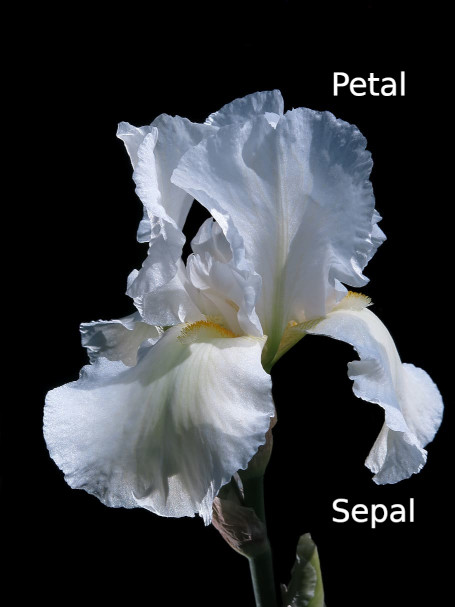

In [ ]:
# Read the dataset
from sklearn.datasets import load_iris

data_bunch = load_iris()

The dataset contains the data records themselves, labels with species names, and the overall description. 

The structure of the loaded dataset reminds a dictionary.

In [ ]:
print(data_bunch.keys())

Key 'data' returns the dataset itself.

In [ ]:
print(data_bunch['data'][:10])

It have a shape as follows:

In [ ]:
print(data_bunch['data'].shape)

There are 150 records and 4 features.

Names of features, i.e., names of the columns can be found in 'feature_names':

In [ ]:
print(data_bunch['feature_names'])

Unlike our previous example, labels of the data are stored as a separate column called 'target':

In [ ]:
print(data_bunch['target'])

We see here just numbers that represent different classes. Names of these classes are in 'target_names`:

In [ ]:
print(data_bunch['target_names'])

Class numbers correspond to the ordering of the names in the list: class 0 is 'setosa', class 1 is 'versicolor', and 2 is 'virginica'.

Also printing of targets reveals that the data are ordered by the class number. 

It means that we must shuffle them before training.

Let us finally see the description of the data:

In [ ]:
print(data_bunch['DESCR'])

We see that there are 50 instances of each classed.

It means we can use simple accuracy for a model evaluation.

All data in centimeters and summary statistics shows that all values are not to far from each other. 

Thus we can not rescale them.

Before building the model let us see at or data.

The dataset if four dimensional so we need some projection to visualize it.

We will use two nonlinear dimension reduction methods, tSNE and MDS. 

After projection of the plane points are shown via scatter plot where colorization is done according to the class number.

In [ ]:
from sklearn.manifold import TSNE, MDS

proj_tsne = TSNE(random_state=0)
Wtsne = proj_tsne.fit_transform(data_bunch['data'])

proj_mds = MDS()
Wmds = proj_mds.fit_transform(data_bunch['data'])

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax[0].scatter(Wtsne[:, 0], Wtsne[:, 1], c=data_bunch['target']);
ax[0].set_title('tSNE')

ax[1].scatter(Wmds[:, 0], Wmds[:, 1], c=data_bunch['target']);
ax[1].set_title('MDS');

We see that our data form very well separated clusters corresponding to three classes.

Before training a model we need to split the dataset into training, validation and test parts.

scikit-lear provides a function for it.

Unfortunately it can split only into two parts. So we apply the splitting twice.

In [ ]:
from sklearn.model_selection import train_test_split

n_test = 30
n_valid = 30
n_train = 90

# First we separate the test set
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    data_bunch['data'], data_bunch['target'], random_state=0, test_size=n_test, shuffle=True)

# Test data and corresponding labels
print(X_test.shape)
print(y_test)

In [ ]:
# Now split X_train_valid into training and validations subsets
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, random_state=0, test_size=n_valid, shuffle=True)

# Training data and corresponding labels
print(X_train.shape)
print(y_train)

# Validation data and corresponding labels
print(X_valid.shape)
print(y_train)

Let us remember: splitting uses random number generator to shuffle the data. 

To obtain identical results at each run we have to provide the same seed for the random number generator. This is parameter `random_state`.

Thus we have data stored in arrays `X_train`, `X_valid` and `X_test` and the corresponding classes in `y_train`, `y_valid` and `y_test`.

Now we can create a model. 

A model is created in scikit-learn as an object. Class that creates kNN classifier is called `KNeighborsClassifier`. 

It has a lot of parameters but we need just `n_neighbors` that specify a number of neighbors $k$ that will be taken into account.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k = 1
knn = KNeighborsClassifier(n_neighbors=1)

Training of scikit-learn models is always performed with the method `.fit`:

In [ ]:
knn.fit(X_train, y_train)

Now the model `knn` is ready to make predictions. This is done with the method `.predict`.

For illustration purpose let us take the first three records in the validation dataset.

In [ ]:
nn = 3
y_pred = knn.predict(X_valid[:nn])
print("Predicted species:", data_bunch['target_names'][y_pred])
print("     True species:", data_bunch['target_names'][y_valid[:nn]])


We see that the model works.

To evaluate its performance let us write a function that accepts datasets and return accuracy.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def evaluate_model(X_train, y_train, X_valid, y_valid, k):
    """Create model, train it and compute accuracy for the validation dataset"""
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_valid)
    return metrics.accuracy_score(y_valid, y_pred)

In [ ]:
import matplotlib.pyplot as plt

ks = list(range(1, 11))

ka_train = [evaluate_model(X_train, y_train, X_train, y_train, k) for k in ks]
ka_valid = [evaluate_model(X_train, y_train, X_valid, y_valid, k) for k in ks]

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(ks, ka_train, label='train')
ax.plot(ks, ka_valid, label='valid')
ax.legend()
ax.grid();

We see that our mode performs well for any $k$. 

For the final score we take $k=2$ since training and validation curves are bit closer to each other.

In [ ]:
k = 2
acc = evaluate_model(X_train, y_train, X_test, y_test, k)
print(f"Final score, acc={acc}")

### kNN regression 

Regression is about prediction of a real number.

Consider how it works using the following example.

Download the dataset 

In [ ]:
data = load_csv_dataset('point-clouds-2.csv')
print(data[:20])

This dataset contains two columns. The first one is considered as $x$ values and the second one are $y$ that depend somehow on $x$ values. 

Also there can be more the one $x$ columns. In that case $y$ are in the last column and it is assumed that $y$ depend on all $x$ values.

The goal is to build a model that takes new unseen $x$ and predicts relevant $y$ for it.

Since we consider the simplest case of two dimensional data, we easily can plot them.

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(data[:, 0], data[:, 1]);

We see here a noisy sin function.

Before creation a model we need to prepare the dataset.

The first column of the data is a train data and the last one are labels.

We will not split the dataset because will evaluate the result just via visual inspection

In [ ]:
X_train = data[:, :1]
y_train = data[:, 1]

Let us create and fit a regression model.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

krg = KNeighborsRegressor(n_neighbors=1)
krg.fit(X_train, y_train)

To check how this prediction works we generate a set of data along $x$ axis and observe the behavior of the predicted dependency $y$ vs $x$

In [ ]:
X_test = np.linspace(-3, 3, 100).reshape(-1, 1)
print(X_test[:10])

Observe how we reshape test values. scikit-learn requires that it must be an array of one column (because our train data also have one column)

In [ ]:
y_pred = krg.predict(X_test)
print(y_pred)

Now we can plot the predicted data

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(X_train.reshape(-1), y_train, label='train')
ax.plot(X_test.reshape(-1), y_pred, color='C1', label='pred')
ax.legend()
ax.grid()

We see that the predicted curve fit the train data very well. 

However notice the stepwise structure of the curve.

Let us check various $k$

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

ks = [1, 3, 9]
X_test = np.linspace(-3, 3, 100).reshape(-1, 1)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(ncols=len(ks), nrows=1, figsize=(5*len(ks), 3))

for k, ax in zip(ks, axs):
    krg = KNeighborsRegressor(n_neighbors=k)
    krg.fit(X_train, y_train)
    y_pred = krg.predict(X_test)
    ax.scatter(X_train.reshape(-1), y_train, label='train')
    ax.plot(X_test.reshape(-1), y_pred, color='C1', label='pred')
    ax.legend()
    ax.grid()
    ax.set_title(f"k={k}")

We see that when only a single neighbor is used each point in the training
set influences on the predictions. 

The predicted values go through all of the data points. 

This leads to a very unsteady prediction

Taking into account more neighbors results in smoother curve, but these do not fit the training data as well.

### Curse of dimensionality

Increasing number of features (number of columns in a dataset) results in the worsening of the kNN algorithm.

This is because it utilizes heavily the idea of closeness of data points in space. 

It works well only when the train data are sufficiently dense in space: each point has a neighbor near it.

High dimensional spaces are vast. 

It means that we need huge amount of the data point to provide a sufficient density. 

In low-dimensional datasets, the closest points tend to be much closer than
average. 

When you have a lot of dimensions, it is likely that the closest points are not much closer than
average.

Let us see an illustration.

We generate low and high dimensional datasets of normally distributed numbers and compute all pairwise distances.

Then plot the histograms for the distances.

In [ ]:
import numpy as np

def all_dist(data):
    """Iterate ofver all pairs of ponts and compute distance"""
    N = len(data)
    ds = []
    for i in range(N):
        for j in range(i+1, N):
            p1 = data[i]
            p2 = data[j]
            ds.append(np.linalg.norm(p1-p2))
    return ds

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()

size = 50

# 2 and 10 dimensional datasets, each having identical sizes
data_2d = rng.uniform(size = (size, 2))
data_10d = rng.uniform(size = (size, 10))

dst_2d = all_dist(data_2d)
dst_10d = all_dist(data_10d)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].hist(dst_2d, bins=100)
axs[0].set_title('2D')
axs[1].hist(dst_10d, bins=100)
axs[1].set_title('10D');

What we observe is that in low dimensional data there are many points that are very close to each other. 

But in high dimensional space the smallest distance is about 0.6

This is because as already mentioned the high dimensional space is vast. 

One need much more points to fill it with sufficient density for kNN to work properly.

Thus kNN should be used for high dimensional data with care.

Probably some of dimension reduction method should be preliminary applied.

### Strengths and weaknesses of kNN

Strong points
- Very easy to understand
- Often gives reasonable performance without a lot of adjustments
- Building the model is usually very fast

Weak points
- Slow predictions when the training dataset is very large
- Does not perform well on datasets with large number of features

In fact it is not often used in practice.

### Exercises

4\. Describe in writing how the confusion matrix is computed in multi-class classification

5\. Describe in writing how precision and recall is computed in multi-class classification

6\. What are macro F1-score and weighted F1-score? Describe their computation in brief.

7\. Download dataset from file "point-clouds-3.csv" that can be found in the repository "https://raw.githubusercontent.com/kupav/data-sc-intro/main/data/". This file contains labeled data. Inspect the data and find the size of the dataset, number of classes, number of instances of each class. Is this dataset well balanced? Using scikit-learn library, create kNN classifier for it. Evaluate the model using an appropriate metrics. Try different $k$, find the best one. Compute the final score for your model.

8\. Download dataset from file "point-clouds-4.csv" that can be found in the repository "https://raw.githubusercontent.com/kupav/data-sc-intro/main/data/". This file contains two-column data. Create a scatter plot for it. Then create a kNN regression model for this data using different $k$. What do you think, why the models do not work properly? What can be done with the data to create better regression models?